# Importar librerias

In [687]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
import plotly.express as px
import scipy.stats

import statsmodels.api as sm
import statsmodels.datasets
import statsmodels.formula.api as smf


import warnings
warnings.filterwarnings("ignore", category=FutureWarning)


# Descarga datos

In [688]:
%run "Download_data.ipynb"

# Funciones especiales

In [689]:
%run "pandas-missing-extension.ipynb"

# Colecta y validación de datos

## ¿Qué tipo de dato son las variables del conjunto de datos?

In [690]:
# Con shape podemos saber las filas y columnas de nuestro DataFrame
print(f"El dataset tiene una cantidad de filas:{df.shape[0]} y columnas:{df.shape[1]}")

El dataset tiene una cantidad de filas:4617 y columnas:18


In [691]:
# Que tipo de variable es cada columna
df.dtypes

Marca                         object
Submarca                      object
Versión                       object
Modelo                         int64
Trans.                        object
Comb.                         object
Cilindros                      int64
Potencia (HP)                  int64
Tamaño (L)                   float64
Categoría                     object
R. Ciudad (km/l)             float64
R. Carr. (km/l)              float64
R. Comb. (km/l)              float64
R. Ajust. (km/l)             float64
CO2(g/km)                      int64
NOx (g/1000km)                 int64
Calificación Gas Ef. Inv.      int64
Calificación Contam. Aire     object
dtype: object

## ¿Cuántas variables de cada tipo de dato tenemos en el conjunto de datos?


In [692]:
(
    df
    .dtypes
    .value_counts()
)

object     7
int64      6
float64    5
Name: count, dtype: int64

## ¿Existen valores nulos explícitos en el conjunto de datos?

In [693]:
(
    df
    .isnull() # Saber si esxisten valores nulos con True o False
    .sum() # Suma de valores nulos por columna
)

Marca                         0
Submarca                      0
Versión                       0
Modelo                        0
Trans.                       16
Comb.                         0
Cilindros                     0
Potencia (HP)                 0
Tamaño (L)                    0
Categoría                     0
R. Ciudad (km/l)              0
R. Carr. (km/l)               0
R. Comb. (km/l)               0
R. Ajust. (km/l)              0
CO2(g/km)                     0
NOx (g/1000km)                0
Calificación Gas Ef. Inv.     0
Calificación Contam. Aire     0
dtype: int64

## ¿Existen valores nulos implicitos en el conjunto de datos?

In [694]:
df.select_dtypes(include='number').min() # Los valores minimos del DataFrame en solo las columnas numericas

Modelo                       2011.000
Cilindros                       3.000
Potencia (HP)                  60.000
Tamaño (L)                      0.898
R. Ciudad (km/l)                3.100
R. Carr. (km/l)                 6.700
R. Comb. (km/l)                 4.960
R. Ajust. (km/l)                3.720
CO2(g/km)                     107.000
NOx (g/1000km)                  0.000
Calificación Gas Ef. Inv.       0.000
dtype: float64

In [695]:
df.select_dtypes(include='number').max() # Los valores minimos del DataFrame en solo las columnas numericas

Modelo                       2018.00
Cilindros                      12.00
Potencia (HP)                 888.00
Tamaño (L)                      8.40
R. Ciudad (km/l)               27.46
R. Carr. (km/l)                31.30
R. Comb. (km/l)                28.93
R. Ajust. (km/l)               21.70
CO2(g/km)                     627.00
NOx (g/1000km)                724.00
Calificación Gas Ef. Inv.      10.00
dtype: float64

<div class="alert alert-info" role="alert">
    <b style="font-size: 1.5em;">👆🏽 <em>Interpretación de máximos y mínimos</em></b>
    <ul>
        <li>La finalidad de esto es ver si existen datos atípicos o nulos en forma de número como con ceros (0)</li>
        <li>Los ceros de las columnas de <code>NOx (g/1000km)</code> y de clasificación de <code>Calificación Gas Ef. Inv.</code> son posibles ya que si existe la posibilidad de vehículos con emisiones cero de óxido de nitrógeno, y la calificación va de 0 a 10</li>
    </ul>
</div>


## ¿Cuál es la proporción de valores nulos por cada variable?


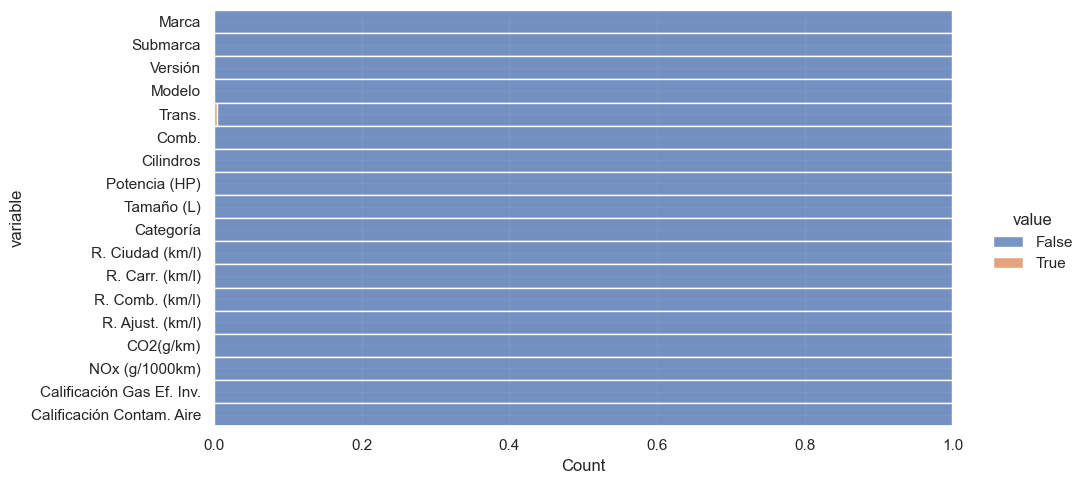

In [696]:
%matplotlib inline
(
    df
    .isnull()
    .melt()
    .pipe(
        lambda df:(
            sns.displot(
                data=df,
                y='variable',
                hue='value',
                multiple='fill',
                aspect=2 # agranda
            )
        )
    )

);

**Los datos faltantes** son muy pocos, como vimos anteriormente, son solo *16* en la columna *Trans.*, que corresponde a la transmisión del vehículo. Estos los podemos agregar manualmente ya que son pocos datos.


In [697]:
df_full = df.copy(deep=True) # Hacemos una copia del DataFrame donde añadiremos nuevos datos


# Conteos y proporciones

Calificación de Gases de Efecto Invernadero: La calificación de contaminantes de efecto invernadero se obtiene a través de un tabulador que utiliza la Agencia de Protección al Medio Ambiente en Estados Unidos (Environment Protection Agency, EPA) para dar calificaciones según las emisiones de CO2 del vehículo, éstas se obtienen principalmente del rendimiento del combustible empleado (gasolina o diesel). La escala que se maneja es del 0 al 10, donde 10 es más eficiente y 0 es menos rendidor en combustible.

Calificación de Contaminantes al Aire: La calificación de contaminantes al aire se obtiene del tabulador que utiliza la EPA para calificar los autos. Este tabulador está relacionado con rangos de emisiones con una escala de 0 a 10, donde 10 es más limpio y 0 es más sucio, el contaminante criterio que se mide es el óxido de nitrógeno (NOx).

**¿Qué significa si mi vehículo tiene una buena calificación de Gases de Efecto Invernadero y mala en Contaminantes al Aire, y viceversa?**

Si su vehículo tiene una buena calificación en gases de efecto invernadero y una mala en contaminantes al aire, significa que es un auto que tiene un buen rendimiento de combustible y que sus emisiones de óxido de nitrógeno (NOx) son muy altas. Por lo tanto, el vehículo no es muy bueno en su control de emisiones (esto puede suceder frecuentemente en el caso de los vehículos a diesel).

Si su vehículo cuenta con una alta calificación de contaminantes al aire y una baja calificación de gases de efecto invernadero, quiere decir que cuenta con un buen sistema de control de contaminantes pero tiene un bajo rendimiento de combustible.

## ¿Qué estadísticos describen el conjunto de datos?

In [698]:
df_full.describe(include=[np.number])

,Modelo,Cilindros,Potencia (HP),Tamaño (L),R. Ciudad (km/l),R. Carr. (km/l),R. Comb. (km/l),R. Ajust. (km/l),CO2(g/km),NOx (g/1000km),Calificación Gas Ef. Inv.
count,4617.000000,4617.000000,4617.000000,4617.000000,4617.000000,4617.000000,4617.000000,4617.000000,4617.00000,4617.000000,4617.000000
mean,2014.187351,5.329218,254.991553,2.869923,10.604934,16.612749,13.183803,9.887754,256.53368,30.803552,4.885207
std,2.162132,1.800226,132.791017,1.347559,3.285876,4.186279,3.603346,2.702537,75.57912,56.901643,2.484840
min,2011.000000,3.000000,60.000000,0.898000,3.100000,6.700000,4.960000,3.720000,107.00000,0.000000,0.000000
25%,2012.000000,4.000000,150.000000,1.800000,8.200000,13.480000,10.460000,7.850000,200.00000,10.000000,3.000000
50%,2014.000000,4.000000,220.000000,2.500000,10.420000,16.390000,12.870000,9.650000,243.00000,17.000000,5.000000
75%,2016.000000,6.000000,330.000000,3.600000,12.810000,19.600000,15.610000,11.710000,299.00000,28.000000,7.000000
max,2018.000000,12.000000,888.000000,8.400000,27.460000,31.300000,28.930000,21.700000,627.00000,724.000000,10.000000


### Resumen de Datos de Consumo de Gasolina

**Modelo**
- **count:** Se dispone de información para 4617 vehículos.

**Características del Motor**
- **Cilindros:** La cantidad promedio de cilindros es 5.33, con un mínimo de 3 y un máximo de 12.
- **Potencia (HP):** La potencia media del motor es de aproximadamente 255 HP, con una variabilidad significativa (desviación estándar de 132.79 HP).
- **Tamaño (L):** El tamaño promedio del motor es 2.87 litros, con un mínimo de 0.898 litros y un máximo de 8.4 litros.

**Rendimiento de Combustible (km/l)**
- **R. Ciudad:** En promedio, se recorren 10.6 km por litro en entornos urbanos.
- **R. Carr.:** El rendimiento en carretera es de aproximadamente 16.6 km por litro en promedio.
- **R. Comb.:** El rendimiento combinado es de 13.18 km por litro en promedio.
- **R. Ajust.:** El rendimiento ajustado tiene una media de 9.89 km por litro.

**Emisiones**
- **CO2(g/km):** La media de emisiones de dióxido de carbono es 256.53 g/km, con un rango que va desde 107 hasta 627 g/km.
- **NOx (g/1000km):** La media de emisiones de óxidos de nitrógeno es 30.8 g por cada 1000 km, con una variabilidad considerable.

**Calificaciones Ambientales**
- **Calificación Gas Ef. Inv.:** La calificación promedio de gas de efecto invernadero es 4.89.

**Estadísticas Generales (Medidas Descriptivas)**
- **Año (Modelo):** Los datos abarcan modelos de vehículos desde 2011 hasta 2018.





<div style="text-align:center;">
<img src="../image/escape.jpeg" alt="Escape" width="800"/>
<p><b>Los NOx y el CO2 son gases muy contaminantes que salen del tubo de escape</b></p>
</div>

<div class="alert alert-info">
    <b style="font-size: 1.5em;">📘 Información CO2 (g/km)</b>
    <br>
    <p>
    <ul>
        <li>El 2020 ha comenzado con la entrada en vigor de una nueva normativa europea que limita las emisiones de dióxido de carbono (CO2) de los vehículos ligeros. Así, a partir de este año, los fabricantes solo podrán vender coches cuyas emisiones no superen los 95 gramos de CO2 por kilómetro recorrido.
        </li>
         <li>En nuestros datos nos encontramos con mínimos de 107 g/km. Exploraremos cuales son los más contaminantes y los menos.
        </li>
    </ul>
    </p>
       <br>
          <br>
    <b style="font-size: 1.5em;">📘 Información NOx (g/km)</b>
    <br>
    <p>
    <ul>
        <li>La actual normativa EURO 6 establece unas emisiones de 80 mg/km de NOx para los vehículos diésel y 60 mg/km de NOx para los motores de gasolina..
        </li>
         <li>En nuestros datos nos encontramos con promedios de 30 g/km. Exploraremos cuales son los más contaminantes y los menos. Pero nos encontramos en un rango más aceptable que el de CO2
        </li>
    </ul>
    </p>
</div>

# Imputación de datos, para valores NaN 

## Completando los valores nulos de la columna Trans. [Transmisión]

Se averigua en internet el tipo de transmisión de los 16 vehículos y se hace una lista con el resultado de los mismos, y se cambia por los datos nulos

In [699]:

# Despues de averiguar en internet (porque eran pocos datos) con ayuda de ADA (IA de Google) obtenemos lista del tipo de tranmision de los vehiculos 
tipo_transmision = ["CVT", "CVT", "CVT", "CVT", "CVT", "CVT","CVT","CVT","CVT","CVT","CVT","CVT","CVT","CVT","CVT","CVT"]
# Filtramos los datos nulos, y los reemplazamos por la lista que creamos
(df_full.loc[df_full['Trans.'].isnull(), 'Trans.']) = tipo_transmision

In [700]:
df_full.isnull().sum() # Nos damos cuenta que contamos con 0 datos Nulos


Marca                        0
Submarca                     0
Versión                      0
Modelo                       0
Trans.                       0
Comb.                        0
Cilindros                    0
Potencia (HP)                0
Tamaño (L)                   0
Categoría                    0
R. Ciudad (km/l)             0
R. Carr. (km/l)              0
R. Comb. (km/l)              0
R. Ajust. (km/l)             0
CO2(g/km)                    0
NOx (g/1000km)               0
Calificación Gas Ef. Inv.    0
Calificación Contam. Aire    0
dtype: int64

## Completando los valores nulos de la columna Calificación Contam. Aire [Calificación de la contaminación del aire]

In [701]:
df["Calificación Contam. Aire"].value_counts()

Calificación Contam. Aire
9    1722
?    1238
8     559
7     471
6     426
5     122
4      41
2      16
3      14
1       8
Name: count, dtype: int64

Cuando una calificación aparece con "?", significa que los datos necesarios para el cálculo no están disponibles para el vehículo, sin embargo, debido a que este vehículo es comercializado en México, sus características de emisiones contaminantes cumplen al menos con la norma NOM-042-SEMARNAT-2003 publicada en el DOF el 7 de septiembre de 2005.

In [702]:
df_full["Calificación Contam. Aire"] = (
    df_full["Calificación Contam. Aire"]
    .replace(
        "?", np.nan # reemplazamos los "?" por valores NaN
    )
)

In [703]:
df_full.isnull().sum() # verificmaos ya existan los valores NaN en la columna

Marca                           0
Submarca                        0
Versión                         0
Modelo                          0
Trans.                          0
Comb.                           0
Cilindros                       0
Potencia (HP)                   0
Tamaño (L)                      0
Categoría                       0
R. Ciudad (km/l)                0
R. Carr. (km/l)                 0
R. Comb. (km/l)                 0
R. Ajust. (km/l)                0
CO2(g/km)                       0
NOx (g/1000km)                  0
Calificación Gas Ef. Inv.       0
Calificación Contam. Aire    1238
dtype: int64

### Imputación basada en modelo

In [704]:
# Cambiamos los nombres de las columnas
df_full.columns = df_full.columns.str.replace(" ", "_") 
df_full.columns = df_full.columns.str.replace(".", "") 
df_full.columns = df_full.columns.str.replace("(", "") 
df_full.columns = df_full.columns.str.replace(")", "") 
df_full.columns = df_full.columns.str.replace("/", "_") 




df_full.head(2)

,Marca,Submarca,Versión,Modelo,Trans,Comb,Cilindros,Potencia_HP,Tamaño_L,Categoría,R_Ciudad_km_l,R_Carr_km_l,R_Comb_km_l,R_Ajust_km_l,CO2g_km,NOx_g_1000km,Calificación_Gas_Ef_Inv,Calificación_Contam_Aire
0,FORD,FUSION,HIBRIDO 4PTS 2.0L 4CIL 188HP AUT (CVT),2015,CVT,Gasolina,4,188,2.0,AUTOS COMPACTOS,27.44,28.57,28.93,21.7,107,5,10,9
1,FORD,FUSION,HIBRIDO 4PTS 2.0L 4CIL 188HP AUT (eCVT),2016,CVT,Gasolina,4,188,2.0,AUTOS COMPACTOS,27.44,28.57,28.93,21.7,107,0,10,9


In [705]:
# convertimos la columna de object a numeric
df_full["Calificación_Contam_Aire"] = pd.to_numeric(df_full["Calificación_Contam_Aire"], errors='coerce')

df_full["Calificación_Contam_Aire"] .dtypes

dtype('float64')

In [706]:
df_full_model= (
    df_full
    .missing.bind_shadow_matrix( # Creamos una matriz de sombra para ver como quedan los datos imputados
        True,
        False,
        suffix = "_imp",
        #only_missing = True
    )
)

df_full_model.head(2)

,Marca,Submarca,Versión,Modelo,Trans,Comb,Cilindros,Potencia_HP,Tamaño_L,Categoría,...,Tamaño_L_imp,Categoría_imp,R_Ciudad_km_l_imp,R_Carr_km_l_imp,R_Comb_km_l_imp,R_Ajust_km_l_imp,CO2g_km_imp,NOx_g_1000km_imp,Calificación_Gas_Ef_Inv_imp,Calificación_Contam_Aire_imp
0,FORD,FUSION,HIBRIDO 4PTS 2.0L 4CIL 188HP AUT (CVT),2015,CVT,Gasolina,4,188,2.0,AUTOS COMPACTOS,...,False,False,False,False,False,False,False,False,False,False
1,FORD,FUSION,HIBRIDO 4PTS 2.0L 4CIL 188HP AUT (eCVT),2016,CVT,Gasolina,4,188,2.0,AUTOS COMPACTOS,...,False,False,False,False,False,False,False,False,False,False


In [707]:
(
    df_full_model
    .pipe(
               
       lambda df: smf.ols("Calificación_Contam_Aire ~ Marca + Modelo + Cilindros + Potencia_HP +Tamaño_L+Calificación_Gas_Ef_Inv +NOx_g_1000km", data=df)        

    )
    .fit()
).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               OLS Regression Results                               
====================================================================================
Dep. Variable:     Calificación_Contam_Aire   R-squared:                       0.696
Model:                                  OLS   Adj. R-squared:                  0.692
Method:                       Least Squares   F-statistic:                     169.3
Date:                      Thu, 25 Jan 2024   Prob (F-statistic):               0.00
Time:                              17:52:54   Log-Likelihood:                -3998.5
No. Observations:                      3379   AIC:                             8089.
Df Residuals:                          3333   BIC:                             8371.
Df Model:                                45                                         
Covariance Type:                  nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                   8.5629     15.178      0.564      0.573     -21.196      38.321
Marca[T.ALFA ROMEO]        -1.2972      0.373     -3.474      0.001      -2.029      -0.565
Marca[T.AUDI]              -0.6821      0.120     -5.662      0.000      -0.918      -0.446
Marca[T.BENTLEY]           -0.2961      0.171     -1.727      0.084      -0.632       0.040
Marca[T.BMW]               -0.7717      0.132     -5.826      0.000      -1.031      -0.512
Marca[T.BUICK]             -0.1855      0.183     -1.016      0.310      -0.543       0.172
Marca[T.CADILLAC]          -0.3903      0.144     -2.709      0.007      -0.673      -0.108
Marca[T.CHEVROLET]         -0.7028      0.121     -5.807      0.000      -0.940      -0.466
Marca[T.CHRYSLER]          -0.3453      0.179     -1.925      0.054      -0.697       0.006
Marca[T.DODGE]             -0.7689      0.132     -5.805      0.000      -1.029      -0.509
Marca[T.FIAT]              -1.3163      0.162     -8.106      0.000      -1.635      -0.998
Marca[T.FORD]               0.1189      0.127      0.933      0.351      -0.131       0.369
Marca[T.GMC]               -0.1661      0.190     -0.876      0.381      -0.538       0.206
Marca[T.GML]               -0.9712      0.575     -1.689      0.091      -2.098       0.156
Marca[T.HONDA]             -0.2264      0.126     -1.790      0.074      -0.474       0.022
Marca[T.HYUNDAI]           -0.4950      0.166     -2.987      0.003      -0.820      -0.170
Marca[T.INFINITI]          -0.6922      0.157     -4.411      0.000      -1.000      -0.385
Marca[T.JAGUAR]            -0.4783      0.250     -1.914      0.056      -0.968       0.012
Marca[T.JEEP]              -0.8978      0.143     -6.295      0.000      -1.177      -0.618
Marca[T.KIA]               -0.1693      0.180     -0.942      0.346      -0.522       0.183
Marca[T.LAMBORGHINI]     3.935e-15   6.29e-16      6.261      0.000     2.7e-15    5.17e-15
Marca[T.LAND ROVER]        -0.2897      0.345     -0.840      0.401      -0.966       0.387
Marca[T.LEXUS]              0.1006      0.574      0.175      0.861      -1.024       1.226
Marca[T.LINCOLN]           -0.2853      0.162     -1.761      0.078      -0.603       0.032
Marca[T.MAYBACH]         1.179e-16   4.81e-16      0.245      0.806   -8.24e-16    1.06e-15
Marca[T.MAZDA]             -0.1802      0.129     -1.399      0.162      -0.433       0.072
Marca[T.MERCEDES]          -0.0198      0.141     -0.140      0.889      -0.297       0.257
Marca[T.MERCURY]            0.2813      0.574      0.490      0.624      -0.845       1.407
Marca[T.MINI]              -1.1189      0.148     -7.561      0.000      -1.409      -0.829
Marca[T.MITSUBISHI]        -0.5317      0.158     -3.360      0.001      

In [708]:
# Usamos un modelo de regresióin lineal con variables del DataFrame
calificacion_aire_ols = (
    df_full_model
    .pipe(
               
       lambda df: smf.ols("Calificación_Contam_Aire ~ Marca + Modelo + Cilindros + Potencia_HP +Tamaño_L+Calificación_Gas_Ef_Inv +NOx_g_1000km", data=df)        

    )
    .fit()
)



In [709]:
# Mostramos que tenemos un R^2 de 68%, algo que indica que el 68% de los datos de ajustan para crear los valores nulos de nuestra columna
calificacion_aire_ols.summary().tables[0]

Dep. Variable:,Calificación_Contam_Aire,R-squared:,0.696
Model:,OLS,Adj. R-squared:,0.692
Method:,Least Squares,F-statistic:,169.3
Date:,"Thu, 25 Jan 2024",Prob (F-statistic):,0.00
Time:,17:52:54,Log-Likelihood:,-3998.5
No. Observations:,3379,AIC:,8089.
Df Residuals:,3333,BIC:,8371.
Df Model:,45,,
Covariance Type:,nonrobust,,


In [710]:
ols_imputed_values = (
    df_full_model
    .pipe(
        lambda df: df[df.Calificación_Contam_Aire.isna()]
    )
    .pipe(
        #lambda df: np.abs(calificacion_aire_ols.predict(df).round())
        lambda df: np.abs(calificacion_aire_ols.predict(df))
    )
)

In [711]:
df_full_model.loc[df_full_model.Calificación_Contam_Aire.isna(), ["Calificación_Contam_Aire"]] = ols_imputed_values
#df_full_model

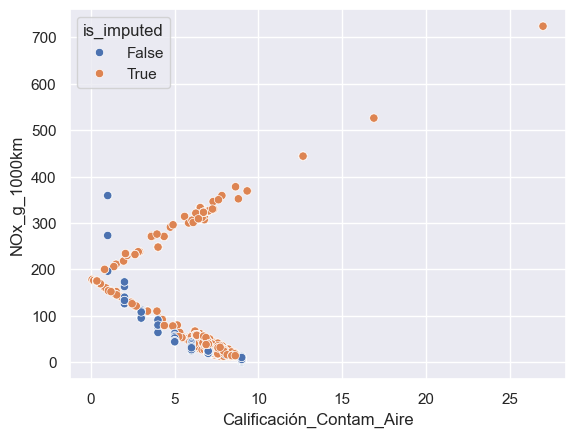

In [712]:

(
    df_full_model
    .missing
    .scatter_imputation_plot(
        x = "Calificación_Contam_Aire",
        y = "NOx_g_1000km"
    )
);

En este grafico podemos ver los valores de NOx (oxido de nitrogeno) y la calificación del aire, en azul vemos los datos que traia el DataFrame y en naranja los datos imputados (antes NaN). Tener en cuenta que la columna NOx_g_1000km no fue usada para la prediccón de la calificacion del aire. 

In [713]:
(df_full[df_full["Calificación_Contam_Aire"].isna()])

,Marca,Submarca,Versión,Modelo,Trans,Comb,Cilindros,Potencia_HP,Tamaño_L,Categoría,R_Ciudad_km_l,R_Carr_km_l,R_Comb_km_l,R_Ajust_km_l,CO2g_km,NOx_g_1000km,Calificación_Gas_Ef_Inv,Calificación_Contam_Aire
19,CHEVROLET,CRUZE,LS 4PTAS 1.4L 4CIL 148HP AUT TURBO,2017,AUT,Gasolina,4,148,1.40,AUTOS COMPACTOS,17.14,28.41,22.15,16.61,140,13,9,NaN
20,CHEVROLET,CRUZE,LT 4PTAS 1.4L 4CIL 148HP AUT TURBO,2017,AUT,Gasolina,4,148,1.40,AUTOS COMPACTOS,17.14,28.41,22.15,16.61,140,13,9,NaN
22,VW,JETTA,MKVI 4PTS 2.0L 4CIL 140HP DSG TURBO DIESEL,2015,DSG,Diesel,4,140,2.00,AUTOS COMPACTOS,17.00,26.10,21.47,16.10,166,95,8,NaN
23,VW,JETTA,MKVI 4PTAS 2.0L 4CIL 140HP DSG TURBO DIESEL,2016,DSG,Diesel,4,140,2.00,AUTOS COMPACTOS,17.00,26.10,21.47,16.10,166,95,8,NaN
24,CHEVROLET,CRUZE,LS 4PTAS 1.4L 4CIL 148HP MAN TURBO,2017,MAN,Gasolina,4,148,1.40,AUTOS COMPACTOS,16.99,27.12,21.72,16.29,143,31,9,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4611,LAND ROVER,RANGE ROVER,SUPERCARGADA 4PTS 5.0L 8CIL 506HP AUT,2011,AUT,Gasolina,8,506,5.00,CAMIONETAS DE USO MULTIPLE (SUV),4.42,9.60,6.97,5.22,446,39,0,NaN
4612,LAND ROVER,RANGE ROVER,SUPERCARGADA 5PTS 5.0L 506HP AUT,2012,AUT,Gasolina,8,506,5.00,CAMIONETAS DE USO MULTIPLE (SUV),4.42,9.60,6.97,5.22,446,39,0,NaN
4613,LAND ROVER,RANGE ROVER,SUPERCARGADA 5PTS 5.0L 8CIL 506HP AUT,2013,AUT,Gasolina,8,506,5.00,CAMIONETAS DE USO MULTIPLE (SUV),4.42,9.60,6.97,5.22,446,39,0,NaN
4614,MERCEDES,G 65,AMG 4X4 5PTAS 6.0L 12CIL 630HP AUT BITURBO,2016,AUT,Gasolina,12,630,5.98,CAMIONETAS DE USO MULTIPLE (SUV),4.41,7.30,6.45,4.84,482,38,0,NaN


In [714]:

df_full.loc[df_full['Calificación_Contam_Aire'].isna(), 'Calificación_Contam_Aire'] = (
    df_full
    .pipe(
        lambda df: df[df.Calificación_Contam_Aire.isna()]
    )
    .pipe(
        lambda df: np.abs(calificacion_aire_ols.predict(df).round())
    )
)


In [715]:
df_full["Calificación_Contam_Aire"].value_counts()

Calificación_Contam_Aire
9.0     1800
8.0     1082
7.0      831
6.0      566
5.0      139
4.0       71
3.0       36
2.0       36
1.0       28
0.0       15
13.0       8
27.0       3
17.0       2
Name: count, dtype: int64

In [716]:
df_full.isnull().sum() # Verificamos no hagan falta datos

Marca                       0
Submarca                    0
Versión                     0
Modelo                      0
Trans                       0
Comb                        0
Cilindros                   0
Potencia_HP                 0
Tamaño_L                    0
Categoría                   0
R_Ciudad_km_l               0
R_Carr_km_l                 0
R_Comb_km_l                 0
R_Ajust_km_l                0
CO2g_km                     0
NOx_g_1000km                0
Calificación_Gas_Ef_Inv     0
Calificación_Contam_Aire    0
dtype: int64

# Preguntas Interesantes

## ¿Cuál es la relación entre la potencia del motor y la eficiencia de combustible?

### Rendimiento en la ciudad y carretera

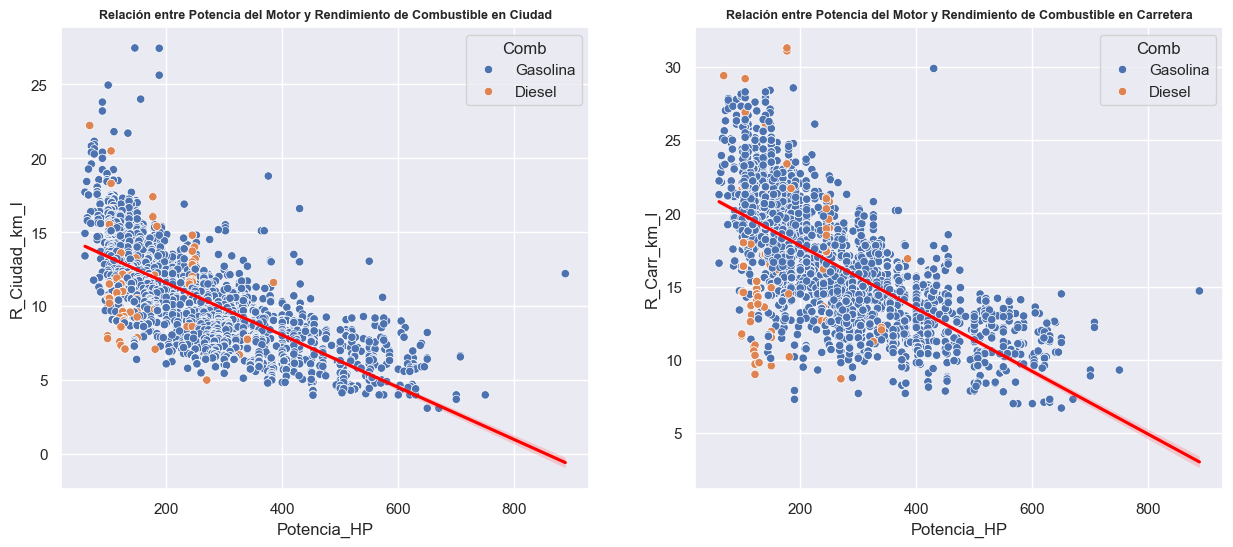

<Figure size 1000x600 with 0 Axes>

In [717]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6));

# Rendimiento en Ciudad

sns.set(style="darkgrid") # Estilo del grafico
plt.figure(figsize=(10, 6)) # Tamaño del grafico
sns.scatterplot(x='Potencia_HP', y='R_Ciudad_km_l', data=df_full, hue="Comb", ax=axes[0]) # Grafico

# Etiquetas
axes[0].set_title('Relación entre Potencia del Motor y Rendimiento de Combustible en Ciudad', fontsize=9, fontweight='bold') # Titulo
#axes[0].set_title('Relación con R_Ciudad_km_l')

# Regresión polinomoica
sns.regplot(x='Potencia_HP', y='R_Ciudad_km_l', data=df_full, order=1, scatter=False, color='red', ax=axes[0])


#Rendimiento en carretera
sns.scatterplot(x='Potencia_HP', y='R_Carr_km_l', data=df_full, hue="Comb", ax=axes[1]) # Grafico
# Etiquetas
axes[1].set_title('Relación entre Potencia del Motor y Rendimiento de Combustible en Carretera', fontsize=9, fontweight='bold') # Titulo
# Regresión polinomoica
sns.regplot(x='Potencia_HP', y='R_Carr_km_l', data=df_full, order=1, scatter=False, color='red', ax=axes[1]);


<div class="alert alert-info" role="alert">
    <b style="font-size: 1.5em;">👆🏽 <em>Relación entre Potencia del Motor y Eficiencia de Combustible en Ciudad y Carretera</em></b>
    <ul>
        <li>Existe una aparente relación inversa entre la potencia del motor y la eficiencia de combustible. A medida que la potencia del motor disminuye, la eficiencia tiende a aumentar y viceversa. Esto podría indicar un trade-off entre rendimiento y eficiencia.</li>
        <li>Los consumidores interesados en maximizar la eficiencia de combustible podrían considerar vehículos con menor potencia. Sin embargo, esta elección puede depender de las necesidades individuales, ya que algunas personas pueden priorizar el rendimiento sobre la eficiencia.</li>
        <li>La eficiencia de combustible es típicamente más baja en condiciones de conducción en ciudad en comparación con la conducción en carretera. Esto se debe a que la conducción en ciudad suele implicar más paradas y arranques, lo que puede afectar negativamente al consumo de combustible.</li>
    </ul>
</div>

## ¿Cómo afecta el tipo de transmisión (`Trans`) al consumo de combustible?

### Separar los datos por Transmisión y combustible

In [718]:
# Filtramos los 5 autos que más rendimiento de gasolina tienen por Transmisión
df_full_diesel_top_5_max = (
    df_full[df_full['Comb'] == 'Diesel']
    .groupby("Trans")[["R_Ciudad_km_l"]]
    .mean()
    .sort_values(by=["R_Ciudad_km_l"],
                 ascending= False)
    .reset_index()
    .head(5)
)

# Filtramos los 5 autos que menos rendimiento de gasolina tienen por Transmisión

df_full_diesel_top_5_min = (
    df_full[df_full['Comb'] == 'Diesel']
    .groupby("Trans")[["R_Ciudad_km_l"]]
    .mean()
    .sort_values(by=["R_Ciudad_km_l"],
                 ascending= False)
    .reset_index()
    .tail(5)
    
)

#________________

# Filtramos los 5 autos que más rendimiento de Diesel tienen por Transmisión
df_full_gasolina_top_5_max = (
    df_full[df_full['Comb'] == 'Gasolina']
    .groupby("Trans")[["R_Ciudad_km_l"]]
    .mean()
    .sort_values(by=["R_Ciudad_km_l"],
                 ascending= False)
    .reset_index()
    .head(5)
)

# Filtramos los 5 autos que menos rendimiento de Diesel tienen por Transmisión
df_full_gasolina_top_5_min = (
    df_full[df_full['Comb'] == 'Gasolina']
    .groupby("Trans")[["R_Ciudad_km_l"]]
    .mean()
    .sort_values(by=["R_Ciudad_km_l"],
                 ascending= False)
    .reset_index()
    .tail(5)
)


### Graficas para combustible a Gasolina

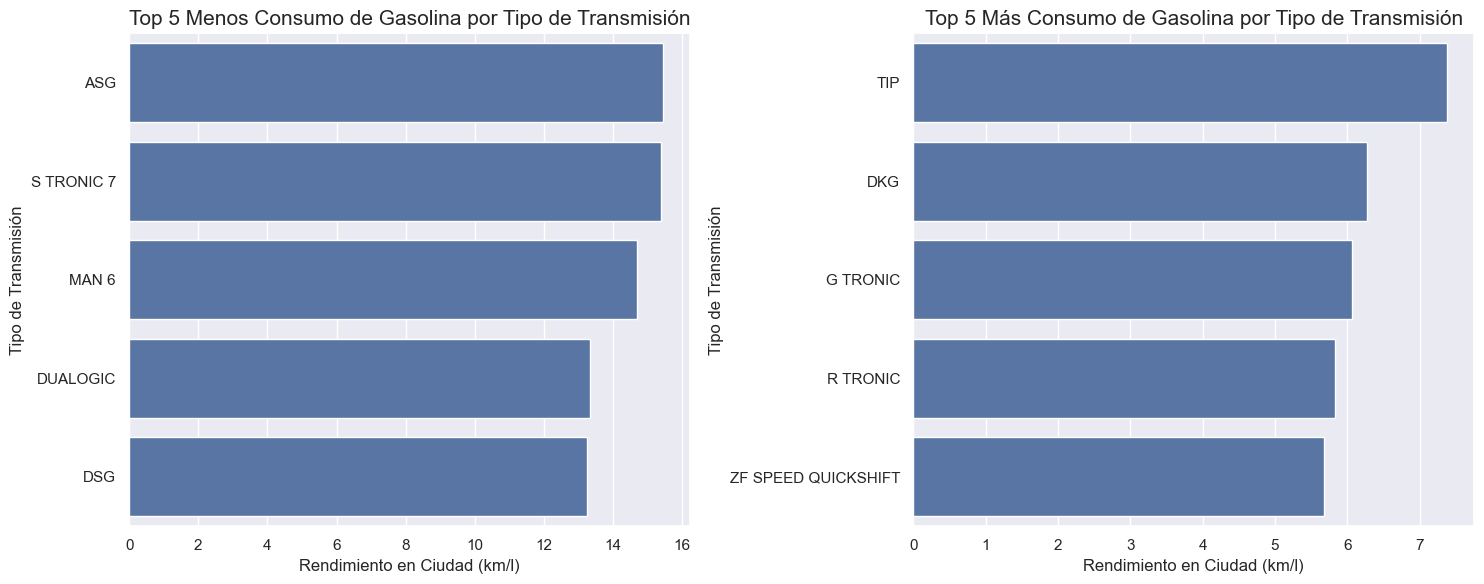

In [719]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6), sharey=False);
sns.set(style="darkgrid") # Estilo del grafico

# Grafico para top 5 mejor consumo gasolina
sns.barplot(data= df_full_gasolina_top_5_max,x="R_Ciudad_km_l", y="Trans", ax=axes[0])
 #Grafico para top 5 peor consumo gasolina
sns.barplot(data= df_full_gasolina_top_5_min,x="R_Ciudad_km_l", y="Trans", ax=axes[1])



axes[0].set_title("Top 5 Menos Consumo de Gasolina por Tipo de Transmisión", size=15)
axes[0].set_xlabel('Rendimiento en Ciudad (km/l)')
axes[0].set_ylabel('Tipo de Transmisión')

axes[1].set_title("Top 5 Más Consumo de Gasolina por Tipo de Transmisión", size=15)
axes[1].set_xlabel('Rendimiento en Ciudad (km/l)')
axes[1].set_ylabel('Tipo de Transmisión')



plt.tight_layout()



<div class="alert alert-info" role="alert">
    <b style="font-size: 1.5em;">ℹ️ Información sobre Transmisiones:</b>
    <ul>
        <li><b>ASG (Automated Manual Transmission):</b> Transmisión manual automatizada. Combina características de una transmisión manual con la automatización de los cambios de marcha. El conductor puede optar por cambiar manualmente o dejar que la transmisión realice los cambios automáticamente.</li>
        <li><b>S TRONIC (Stronic):</b> Marca registrada de Audi para sus transmisiones de doble embrague. Ofrece cambios de marcha rápidos y suaves.</li>
        <li><b>MAN 6 (Manual 6-speed):</b> Transmisión manual de 6 velocidades. El conductor realiza los cambios de marcha de forma manual.</li>
        <li><b>DUALOGIC:</b> Sistema de transmisión automatizada desarrollado por Fiat. Similar a ASG, proporciona la opción de cambios manuales o automáticos.</li>
        <li><b>DSG (Direct-Shift Gearbox):</b> Marca registrada de Volkswagen para su transmisión de doble embrague. Ofrece cambios de marcha rápidos y eficientes.</li>
        <li><b>TIP (Tiptronic):</b> Marca registrada de Audi y Porsche para su transmisión automática con opción de cambio manual secuencial.</li>
        <li><b>DKG (Doppelkupplungsgetriebe):</b> Transmisión de doble embrague. Similar al DSG, es un tipo de transmisión de doble embrague utilizada por BMW.</li>
        <li><b>G TRONIC (G-Tronic):</b> Marca registrada de Mercedes-Benz para su transmisión automática. Puede tener diferentes variantes, como 7G-Tronic o 9G-Tronic, que indican el número de marchas.</li>
        <li><b>R TRONIC:</b> Transmisión automática secuencial de Audi utilizada en algunos modelos de alto rendimiento.</li>
        <li><b>ZF SPEED QUICKSHIFT:</b> ZF es una empresa que fabrica transmisiones. La referencia a "SPEED QUICKSHIFT" podría indicar una transmisión automática con cambios de marcha rápidos.</li>
    </ul>
</div>


<div class="alert alert-info" role="alert">
    <b style="font-size: 1.5em;">📉 <em>Top 5 <u>Menos</u> Consumo de Gasolina por Tipo de Transmisión</em></b>
    <ul>
        <li>Los vehículos con transmisión tipo <b>ASG (Automated Manual Transmission)</b> presentan el mejor rendimiento de combustible en ciudad, con un destacado promedio de alrededor de 15.45 km/l. Esta transmisión se destaca por su eficiencia en el consumo de gasolina.</li>
        <li>Otra opción eficiente es la transmisión <b>S TRONIC (Stronic)</b>, que se encuentra entre las que menos consumen gasolina, con un promedio cercano a 15.38 km/l. Aquellos preocupados por el consumo de combustible podrían considerar vehículos equipados con esta transmisión.</li>
    </ul>
</div>

<div class="alert alert-info" role="alert">
    <b style="font-size: 1.5em;">📈 <em>Top 5 <u>Más</u> Consumo de Gasolina por Tipo de Transmisión</em></b>
    <ul>
        <li>Los vehículos con transmisión tipo <b>ZF SPEED QUICKSHIFT</b> presentan uno de los peores rendimientos de combustible en ciudad, con un promedio de aproximadamente 5.68 km/l. Este tipo de transmisión se sitúa entre los menos eficientes en términos de consumo de gasolina.</li>
        <li>Otra transmisión menos eficiente es el tipo <b>R TRONIC</b>, con un promedio de alrededor de 5.84 km/l. Aquellos que buscan eficiencia en combustible podrían considerar alternativas a este tipo de transmisión.</li>
        <li>Las transmisiones mas comunes que conocemos es la <b>AUTOMATICA</b>, con un promedio de alrededor de 9.73 km/l., consumiendo mas que la transmisión <b>MANUAL</b>, con un promedio de alrededor de 11.89 km/l.</li>
    </ul>
</div>

### Graficas para combustible a Diesel

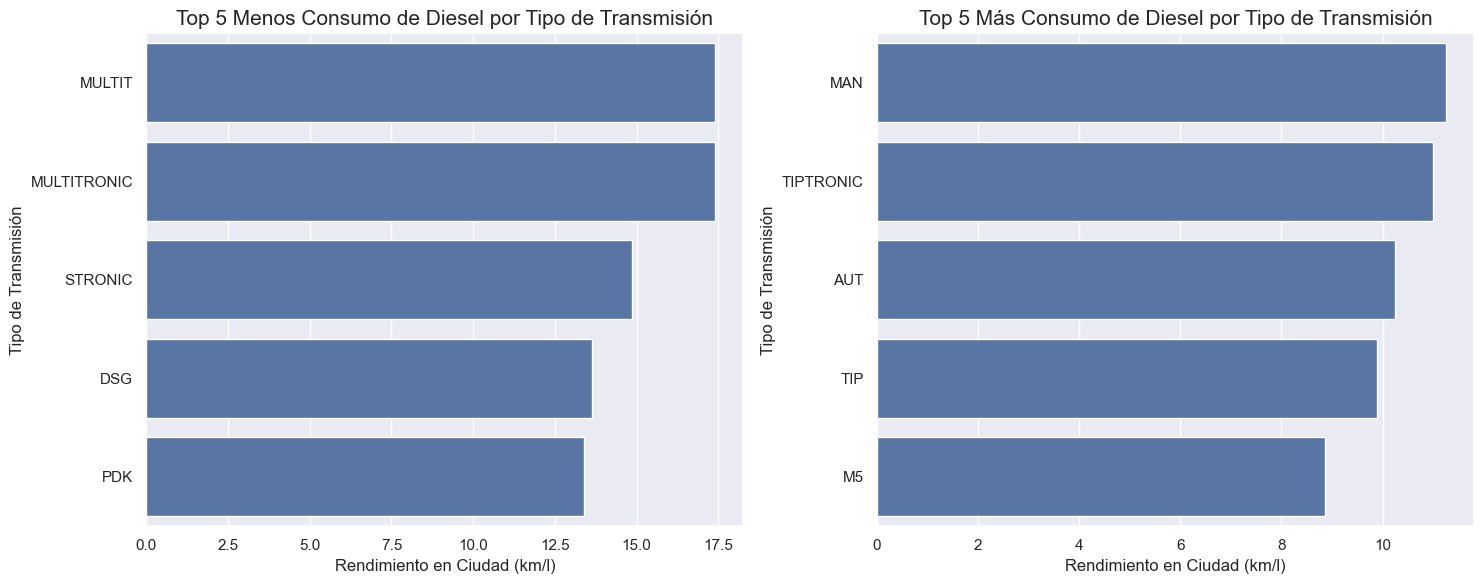

In [720]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6), sharey=False);
sns.set(style="darkgrid") # Estilo del grafico

# Grafico para top 5 mejor consumo Diesel
sns.barplot(data= df_full_diesel_top_5_max,x="R_Ciudad_km_l", y="Trans", ax=axes[0])
 #Grafico para top 5 peor consumo Diesel
sns.barplot(data= df_full_diesel_top_5_min,x="R_Ciudad_km_l", y="Trans", ax=axes[1])



axes[0].set_title("Top 5 Menos Consumo de Diesel por Tipo de Transmisión", size=15)
axes[0].set_xlabel('Rendimiento en Ciudad (km/l)')
axes[0].set_ylabel('Tipo de Transmisión')

axes[1].set_title("Top 5 Más Consumo de Diesel por Tipo de Transmisión", size=15)
axes[1].set_xlabel('Rendimiento en Ciudad (km/l)')
axes[1].set_ylabel('Tipo de Transmisión')



plt.tight_layout()

<div class="alert alert-info" role="alert">
    <b style="font-size: 1.5em;">ℹ️ Información sobre Transmisiones Diesel:</b>
    <ul>
        <li><b>MAN (Manual):</b> Transmisión manual. El conductor realiza los cambios de marcha de forma manual mediante la palanca de cambios.</li>
        <li><b>TIPTRONIC:</b> Transmisión automática con opción de cambios manuales secuenciales. Permite al conductor cambiar de marcha manualmente si lo desea.</li>
        <li><b>AUT (Automática):</b> Transmisión automática convencional. Cambios de marcha automáticos sin intervención directa del conductor.</li>
        <li><b>TIP (Tiptronic):</b> Transmisión automática con opción de cambio manual secuencial. Similar a TIPTRONIC, ofrece cambios manuales si se desea.</li>
        <li><b>M5:</b> Tipo de transmisión no especificado (se recomienda verificar documentación específica del vehículo).</li>
        <li><b>MULTIT:</b> Transmisión Multitronic. Sistema de transmisión automática continuamente variable (CVT) utilizado por Audi.</li>
        <li><b>MULTITRONIC:</b> Transmisión Multitronic. Similar a MULTIT, es un sistema CVT utilizado por Audi.</li>
        <li><b>STRONIC:</b> Transmisión Stronic. Marca registrada de Audi para sus transmisiones automáticas de doble embrague.</li>
         <li><b>DSG (Direct-Shift Gearbox):</b> Marca registrada de Volkswagen para su transmisión de doble embrague. Ofrece cambios de marcha rápidos y eficientes.</li>
        <li><b>PDK (Porsche Doppelkupplungsgetriebe):</b> Transmisión de doble embrague desarrollada por Porsche. Similar al DSG, proporciona cambios de marcha rápidos y suaves.</li>
    </ul>
</div>


<div class="alert alert-info" role="alert">
    <b style="font-size: 1.5em;">📉 <em>Top 5 <u>Menos</u> Consumo de Diesel por Tipo de Transmisión</em></b>
    <ul>
        <li>En el extremo opuesto, las transmisiones diesel tipo <b>MULTIT</b> (Multitronic) y <b>MULTITRONIC</b> (Multitronic) muestran el mejor rendimiento de combustible en ciudad, con un destacado promedio de 17.4 km/l. Estas transmisiones se destacan por su eficiencia en el consumo de combustible.</li>
        <li>Otras opciones eficientes son las transmisiones diesel tipo <b>STRONIC</b> (Stronic) y <b>DSG</b> (Direct-Shift Gearbox), con promedios de alrededor de 14.85 km/l y 13.63 km/l respectivamente. Aquellos preocupados por el consumo de combustible podrían considerar vehículos equipados con estas transmisiones diesel.</li>
    </ul>
</div>

<div class="alert alert-info" role="alert">
    <b style="font-size: 1.5em;">📈 <em>Top 5 <u>Más</u> Consumo de Diesel por Tipo de Transmisión</em></b>
    <ul>
        <li>Los vehículos con transmisión tipo <b>M5</b> presentan el mayor consumo de combustible en ciudad, con un promedio de aproximadamente 8.86 km/l. Esta transmisión podría no ser la opción más eficiente en términos de consumo de combustible diesel.</li>
        <li>Otra transmisión con alto consumo es <b>MAN (Manual)</b>, con un promedio de alrededor de 11.25 km/l. Aunque no es la transmisión con el mayor consumo, es importante tener en cuenta este valor al considerar la eficiencia en combustible.</li>
    </ul>
</div>

## ¿Cuál es la relación entre la categoría del vehículo y la eficiencia de combustible?

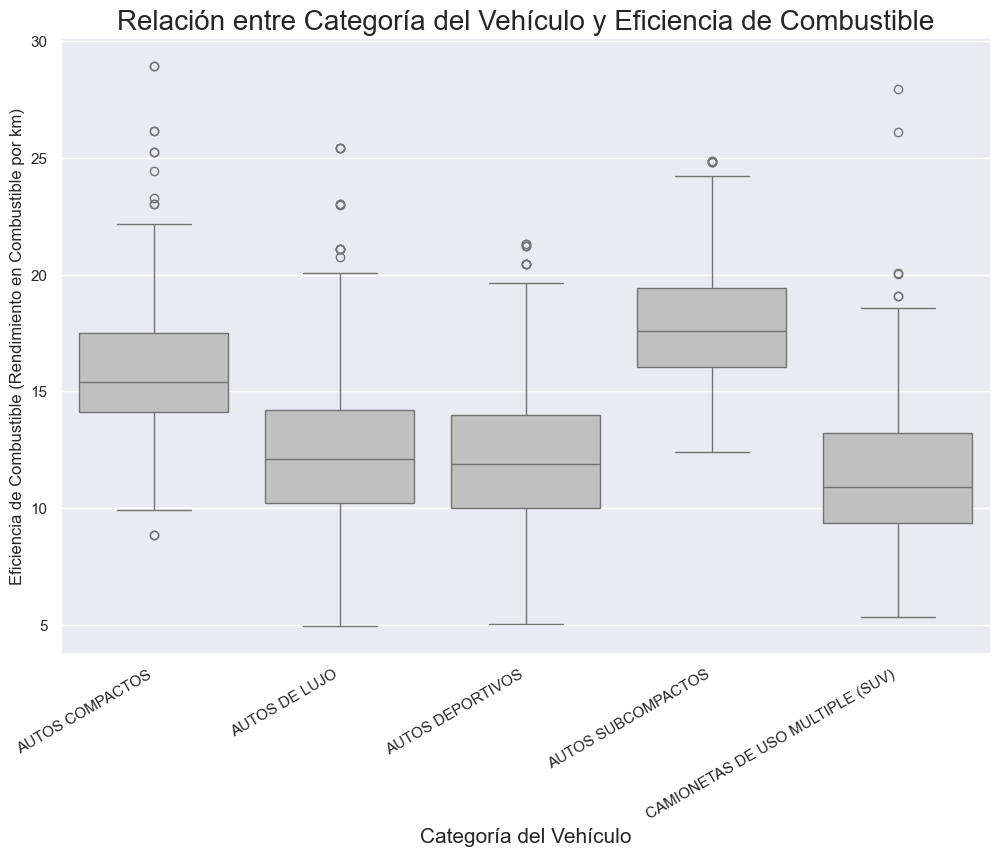

In [721]:
# Graficando boxplot para ver los datos
plt.figure(figsize=(12, 8))

sns.boxplot(x='Categoría', y='R_Comb_km_l', data=df_full,color="silver")

plt.title('Relación entre Categoría del Vehículo y Eficiencia de Combustible', size=20)
plt.xlabel('Categoría del Vehículo', size=15);
plt.ylabel('Eficiencia de Combustible (Rendimiento en Combustible por km)')
plt.xticks(rotation=30, ha='right')  # Rotar etiquetas del eje x para mejor visualización
plt.show()

<div class="alert alert-info" role="alert">
    <b style="font-size: 1.5em;">📉📈 <em>Conclusiones sobre Eficiencia de Combustible por Categoría de Vehículo</em></b>
    <ul>
        <li><b>Autos Compactos:</b> Con un promedio de 15.70 km/l, los autos compactos exhiben un buen rendimiento en eficiencia de combustible. La mediana se sitúa en 15.41 km/l.</li>
        <li><b>Autos de Lujo:</b> Aunque muestran una eficiencia promedio menor (12.33 km/l), los autos de lujo tienen una variabilidad significativa en su rendimiento de combustible.</li>
        <li><b>Autos Deportivos:</b> Con una eficiencia promedio de 12.29 km/l, los autos deportivos también presentan variabilidad en su consumo de combustible.</li>
        <li><b>Autos Subcompactos:</b> Liderando en eficiencia con un promedio de 17.82 km/l, los autos subcompactos muestran una distribución sesgada hacia valores más altos.</li>
        <li><b>Camionetas SUV:</b> Con el menor promedio de 11.36 km/l, las camionetas SUV exhiben la eficiencia de combustible más baja entre las categorías analizadas.</li>
    </ul>
  <div>
    <p>Los autos con mejor rendimiento de combustible son los <b>Autos Subcompactos</b>, vehículos pequeños y ágiles diseñados para acomodar de manera cómoda a cuatro o cinco pasajeros. Gracias a su tamaño compacto, tienen la capacidad de maniobrar con facilidad en espacios reducidos, convirtiéndolos en una elección óptima para enfrentar el tráfico congestionado. Algunos ejemplos de vehículos de este tipo comunes en México son:</p>
    <ul>
        <li>Nissan March</li>
        <li>Chevrolet Spark</li>
        <li>Honda Fit</li>
        <li>Kia Rio</li>
    </ul>
</div>

</div>




## ¿Cuál es la tendencia temporal en las calificaciones de gases de efecto invernadero a lo largo de los modelos (`Modelo`)?

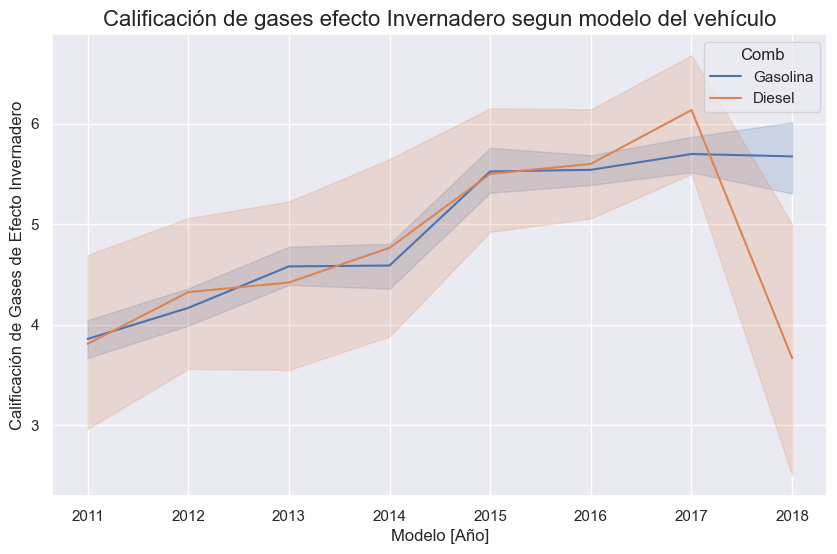

In [749]:
plt.figure(figsize=(10, 6))
(
    df_full[["Modelo", "Calificación_Gas_Ef_Inv","Comb"]]
    .pipe(
        lambda df:(
            sns.lineplot(data=df, x="Modelo", y="Calificación_Gas_Ef_Inv", hue="Comb")
        )
    )
);

plt.title('Calificación de gases efecto Invernadero segun modelo del vehículo',size=16);
plt.xlabel('Modelo [Año]');
plt.ylabel('Calificación de Gases de Efecto Invernadero');


<div class="alert alert-info" role="alert">
    <b style="font-size: 1.5em;">ℹ️ Conclusión sobre Calificaciones de Gases de Efecto Invernadero por Combustible</b>
    <ul>
        <li>En general, los modelos de vehículos, ya sea con motor Diesel o Gasolina, tienen calificaciones de gases de efecto invernadero (GEI) bastante cercanas. Ambos grupos tienen un promedio alrededor de 4.88, indicando una eficiencia moderada en la reducción de emisiones de GEI.</li>
        <li>La mayoría de los modelos, independientemente del tipo de combustible, se centran en calificaciones de GEI entre 3 y 5, con una pequeña proporción que alcanza valores más altos, especialmente en el caso de vehículos a gasolina.</li>
        <li>Es importante tener en cuenta que la eficiencia en la reducción de GEI también depende de otros factores, como el tamaño del vehículo, la tecnología de emisiones utilizada y las regulaciones ambientales aplicables en el momento de la fabricación.</li>
    </ul>
</div>


## ¿Cómo se distribuyen las emiciones de CO2 en función de la categoría de vehículo?

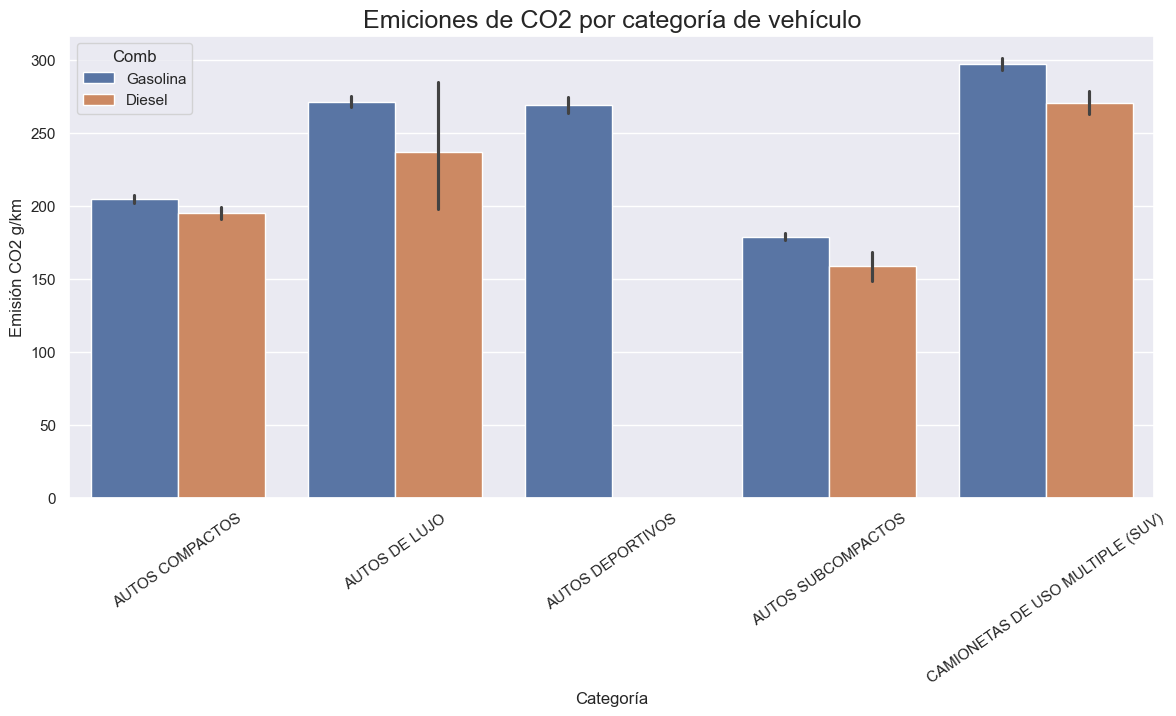

In [759]:
plt.figure(figsize=(14, 6))
(
    df_full[["Categoría", "CO2g_km","Comb"]]
    .pipe(
        lambda df: sns.barplot(
            data=df,
            x="Categoría",
            y="CO2g_km",
            hue="Comb"
        )
    )

)

# Girar el texto del eje x en 45 grados
plt.xticks(rotation=35)

plt.title('Emiciones de CO2 por categoría de vehículo',size=18);
plt.xlabel('Categoría');
plt.ylabel('Emisión CO2 g/km');

<div class="alert alert-info" role="alert">
    <b style="font-size: 1.5em;">🌍 Emisiones de CO2 por Combustible:</b>
    <ul>
        <li><b>Emisiones Medias:</b>
            <ul>
                <li>En promedio, los vehículos a gasolina tienen ligeramente mayores emisiones de CO2 por kilómetro en comparación con los vehículos a diesel.</li>
                <li>Los vehículos a diesel muestran un promedio de aproximadamente 254.57 g/km, mientras que los vehículos a gasolina tienen un promedio de alrededor de 256.62 g/km.</li>
            </ul>
        </li>
        </li>
        <li><b>Rango de Emisiones:</b>
            <ul>
                <li>El rango de emisiones es más amplio para los vehículos a gasolina, con un mínimo de 107 g/km y un máximo de 627 g/km. En contraste, los vehículos a diesel tienen un rango más estrecho, oscilando entre 137 g/km y 487 g/km.</li>
            </ul>
        </li>
        <li><b>Autos deportivos:</b>
            <ul>
                <li><b>Rendimiento y Potencia:</b> Los motores de gasolina tienden a ofrecer una respuesta más rápida y una mayor potencia específica en comparación con los motores diesel. Esto es esencial para los autos deportivos, donde la aceleración y la velocidad máxima son consideraciones clave.</li>
            </ul>
        </li>
        

## ¿Qué significa si mi vehículo tiene una buena calificación de Gases de Efecto Invernadero y mala en Contaminantes al Aire, y viceversa?

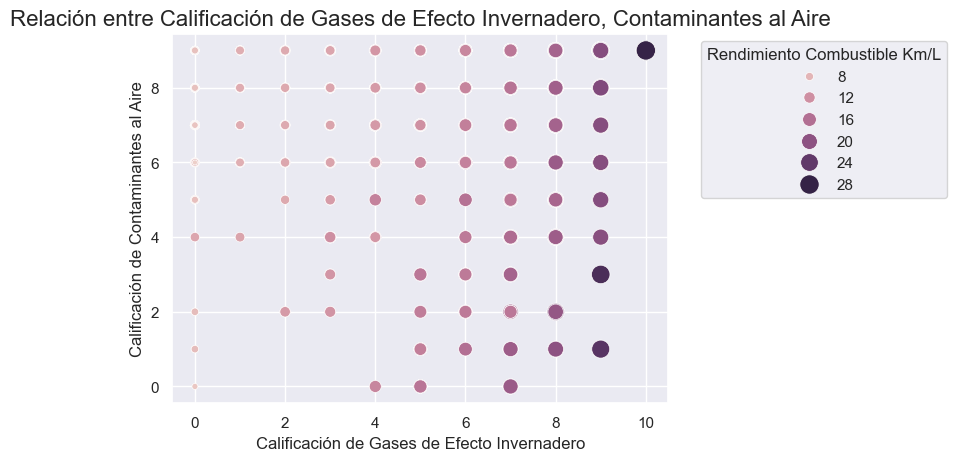

In [872]:
(
    df_full[df_full["Calificación_Contam_Aire"] <= 10 ]
    [["Calificación_Gas_Ef_Inv","Calificación_Contam_Aire","R_Comb_km_l"]]
    .pipe(
        lambda df: sns.scatterplot(
            x="Calificación_Gas_Ef_Inv", 
            y="Calificación_Contam_Aire", 
            hue="R_Comb_km_l", 
            size="R_Comb_km_l",
            sizes=(10, 200),
            alpha=1,
            data=df
            )


    )
)

plt.xlabel("Calificación de Gases de Efecto Invernadero")
plt.ylabel("Calificación de Contaminantes al Aire")
plt.title("Relación entre Calificación de Gases de Efecto Invernadero, Contaminantes al Aire", size=16)
plt.legend(title="Rendimiento Combustible Km/L", bbox_to_anchor=(1.05, 1), loc='upper left');



<div class="alert alert-info">
    <b style="font-size: 1.5em;">📘 Información</b>
    <p>
        <ul>
            <li>En relación con la presente consulta, la <a href="https://ecovehiculos.inecc.gob.mx/cake/Pages/preguntasfrecuentes" target="_blank">página oficial del gobierno</a> ofrece la siguiente explicación:</li>
            <ul>
                <li>Si su vehículo cuenta con una calificación favorable en gases de efecto invernadero pero obtiene una calificación baja en contaminantes al aire, esto indica que el automóvil tiene un buen rendimiento de combustible, pero sus emisiones de óxido de nitrógeno (NOx) son considerablemente altas. Por lo tanto, el vehículo puede carecer en eficiencia en el control de emisiones, una situación que se presenta con frecuencia en vehículos a diesel.</li>
                <li>Contrariamente, si el vehículo muestra una alta calificación en contaminantes al aire pero una baja calificación en gases de efecto invernadero, esto sugiere que tiene un sistema efectivo de control de contaminantes, aunque su rendimiento de combustible es menor.</li>
            </ul>
        </ul>
    </p>
    <b style="font-size: 1.5em;">📊 Representado en datos</b>
    <p>
        <ul>
            <li>Para visualizar esta información, hemos representado en un gráfico de dispersión, utilizando el eje x para la calificación de gases de efecto invernadero y el eje y para la calificación de contaminación del aire. El tamaño y color de los puntos indican el rendimiento de combustible (km/l): entre más grande y de color más intenso sea el círculo, mejor será el rendimiento, y viceversa.</li>
            <ul>
                <li>Observamos que los puntos más grandes se encuentran en las calificaciones más altas de gases de efecto invernadero. Esto confirma que, en general, los vehículos con un rendimiento de combustible superior tienden a tener calificaciones superiores en gases de efecto invernadero, independientemente de su calificación en contaminantes del aire.</li>
                <li>En contraste, los vehículos con una buena calificación en contaminantes del aire y una baja calificación en gases de efecto invernadero muestran puntos más pequeños y de color claro. Esto sugiere que, para lograr un buen rendimiento de combustible, es crucial prestar más atención a la calificación de gases de efecto invernadero que a la calificación de contaminantes del aire.</li>
            </ul>
        </ul>
    </p>
</div>

